In [11]:
### not bounding f^*_V

import numpy as np
from scipy.integrate import odeint, solve_ivp
from utils import seir_ivp, run_modified_seir_ivp, plot_scenarios_size
import pandas as pd

def run_scenarios_size(y0: list, t: int, size: float, R0s: np.ndarray, sigma: float, gamma: float, \
    epss: np.ndarray, measured: int):  
    s0, e0, i0, r0 = y0
    df_R0s = []; df_epss = []; df_fvs = []
    covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_covs = []
    df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []
    df_rs = []; df_rleakys = []; df_raons = []

    for R0 in R0s:
        beta = R0 * gamma
        sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True)
        #r = sol.y[3]; r10 = r[-1]*0.1; r25 = r[-1]*0.25

        def _reach_size10(t, y, beta, sigma, gamma): return y[3] - 0.1
        def _reach_size25(t, y, beta, sigma, gamma): return y[3] - 0.25

        _reach_size10.terminate=True
        _reach_size25.terminate=True
                
        for eps in epss:
            if size == 0:
                fc = 1/eps * (1 - 1/R0)
                tv = -1
                t_new = measured
            else:
                if size == 0.1:
                    sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), \
                        events=_reach_size10, dense_output=True)
                elif size == 0.25:
                    sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), \
                        events=_reach_size25, dense_output=True)

                if np.array(sol.t_events).size == 0:
                    fc = 99999; fv = 99999; r_perc_leaky = 99999; r_perc_aon = 99999; r_perc_diff = 99999
                else:
                    s_temp = np.ravel(np.array(sol.y_events[0]))[0]
                    tv = np.ravel(np.array(sol.t_events))[0]
                    fc = 1/eps * (1 - 1/(R0*s_temp))
                    t_new = tv + measured
                        
            for cov in covs:
                if fc != 99999:
                    if cov == 'Below fc':
                        fv = fc * 0.8
                    elif cov == 'Slightly Above fc':
                        fv = 1 - ((1 - fc) * 0.8)
                    else:
                        fv = 1 - ((1 - fc) * 0.5)
                        
                    sol_vax = solve_ivp(seir_ivp, [0, t_new], y0, args=(beta, sigma, gamma), dense_output=True)
                    r_vax = sol_vax.y[3]
                        
                    _, _, _, _, _, _, r_leaky = run_modified_seir_ivp(y0, t_new, tv, beta, sigma, gamma, fv, eps, mode='leaky')
                    _, _, _, _, _, _, r_aon = run_modified_seir_ivp(y0, t_new, tv, beta, sigma, gamma, fv, eps, mode='aon')

                    r_perc_leaky = (r_vax[-1] - r_leaky[-1]) / r_vax[-1] * 100
                    r_perc_aon = (r_vax[-1] - r_aon[-1]) / r_vax[-1] * 100
                    r_perc_diff = abs(r_perc_aon - r_perc_leaky)

                df_R0s.append(R0)
                df_epss.append(eps)
                df_fvs.append(fv)
                df_covs.append(cov)
                df_r_perc_leakys.append(r_perc_leaky)
                df_r_perc_aons.append(r_perc_aon)
                df_r_perc_diffs.append(r_perc_diff)

    # build dataframe                        
    data = {'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
        'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs}
    vax_df = pd.DataFrame(data=data)

    return vax_df

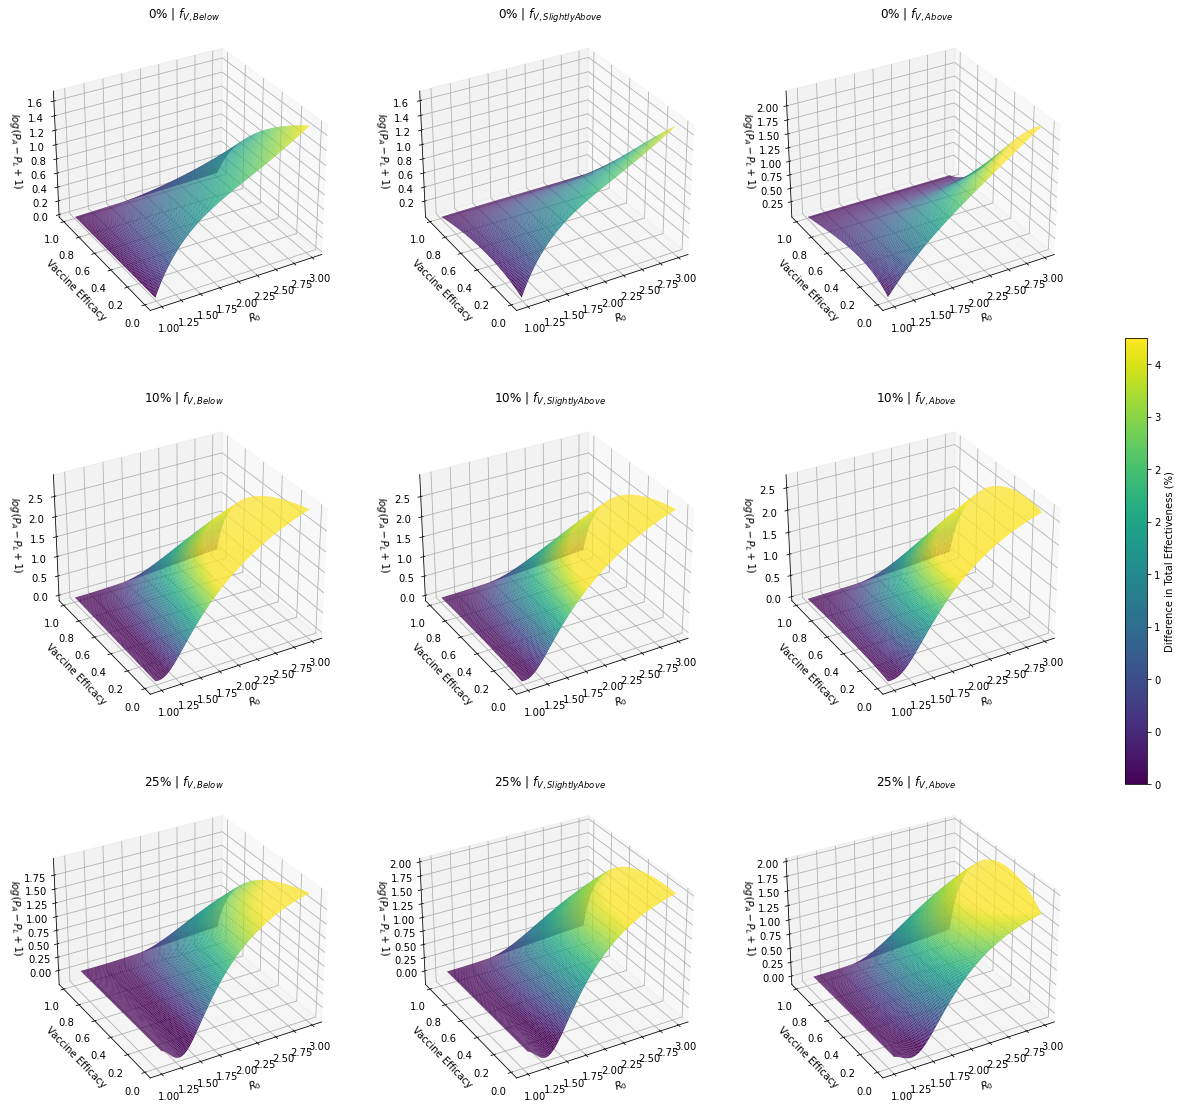

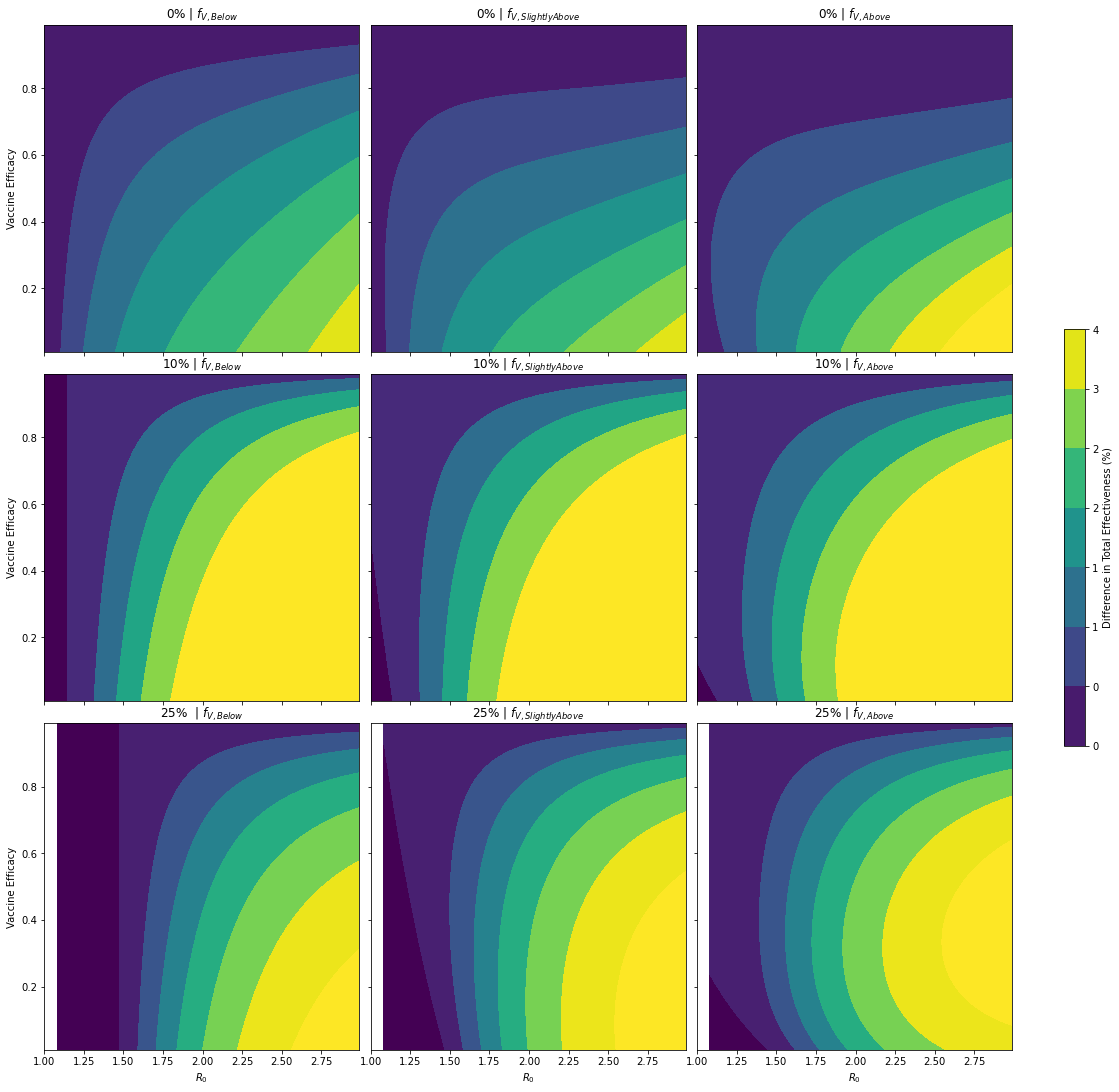

In [7]:
# define parameter values and initial conditions
sigma = 1/4; gamma = 1/4; t = 200
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
R0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

# run scenarios varying R0 values and vaccine efficacy
epi0_m30 = run_scenarios_size(y0, t, 0, R0s, sigma, gamma, epss, measured=30)
epi10_m30 = run_scenarios_size(y0, t, 0.1, R0s, sigma, gamma, epss, measured=30)
epi25_m30 = run_scenarios_size(y0, t, 0.25, R0s, sigma, gamma, epss, measured=30)

# plot difference in total effectiveness for each scenario
fig_3d = plot_scenarios_size(epi0_m30, epi10_m30, epi25_m30, dim=3)
fig_2d = plot_scenarios_size(epi0_m30, epi10_m30, epi25_m30, dim=2)

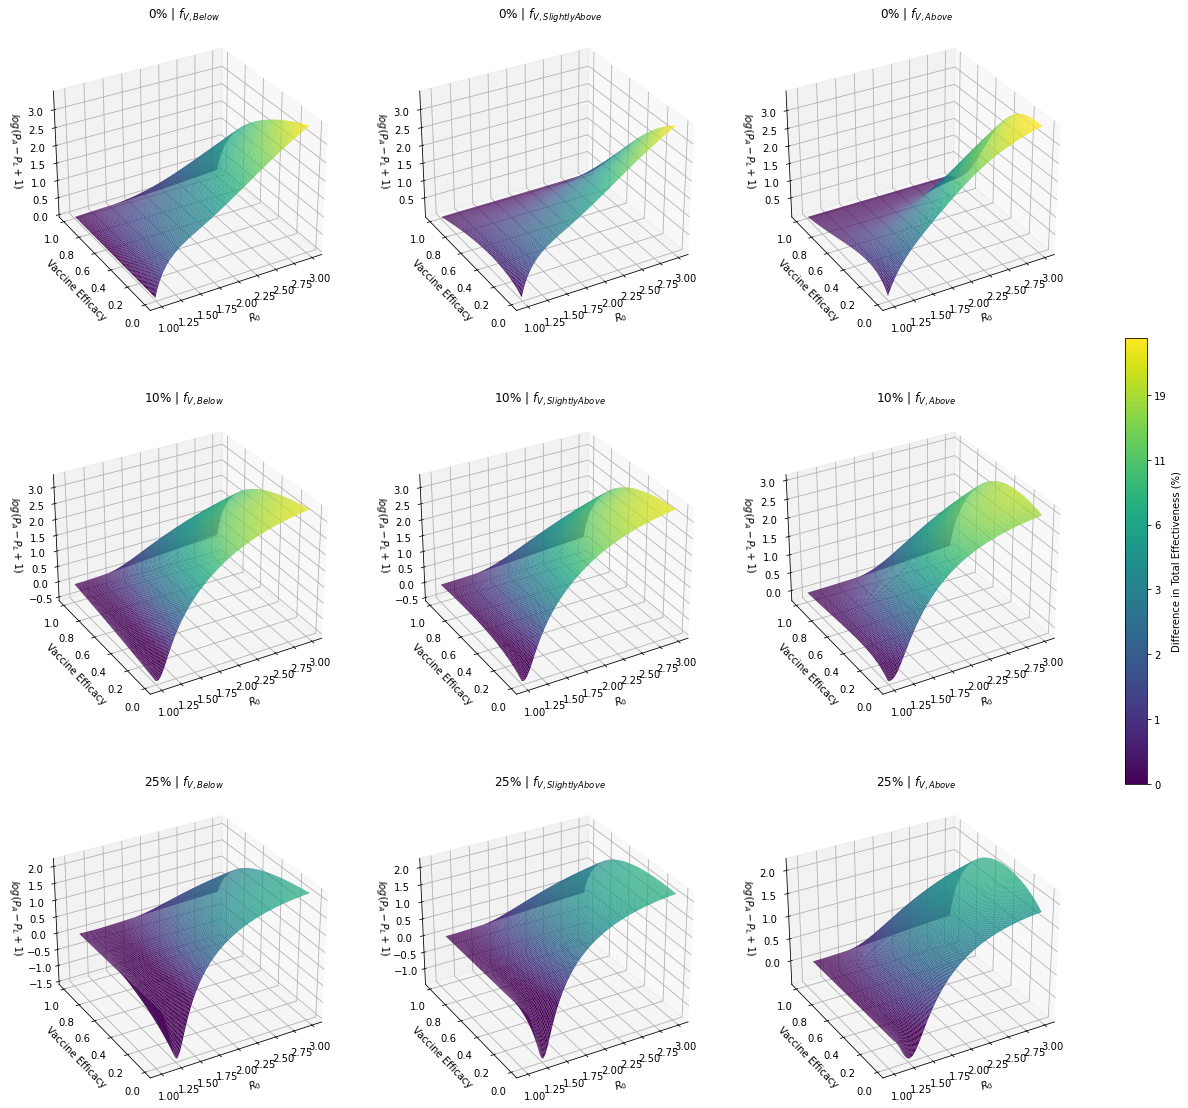

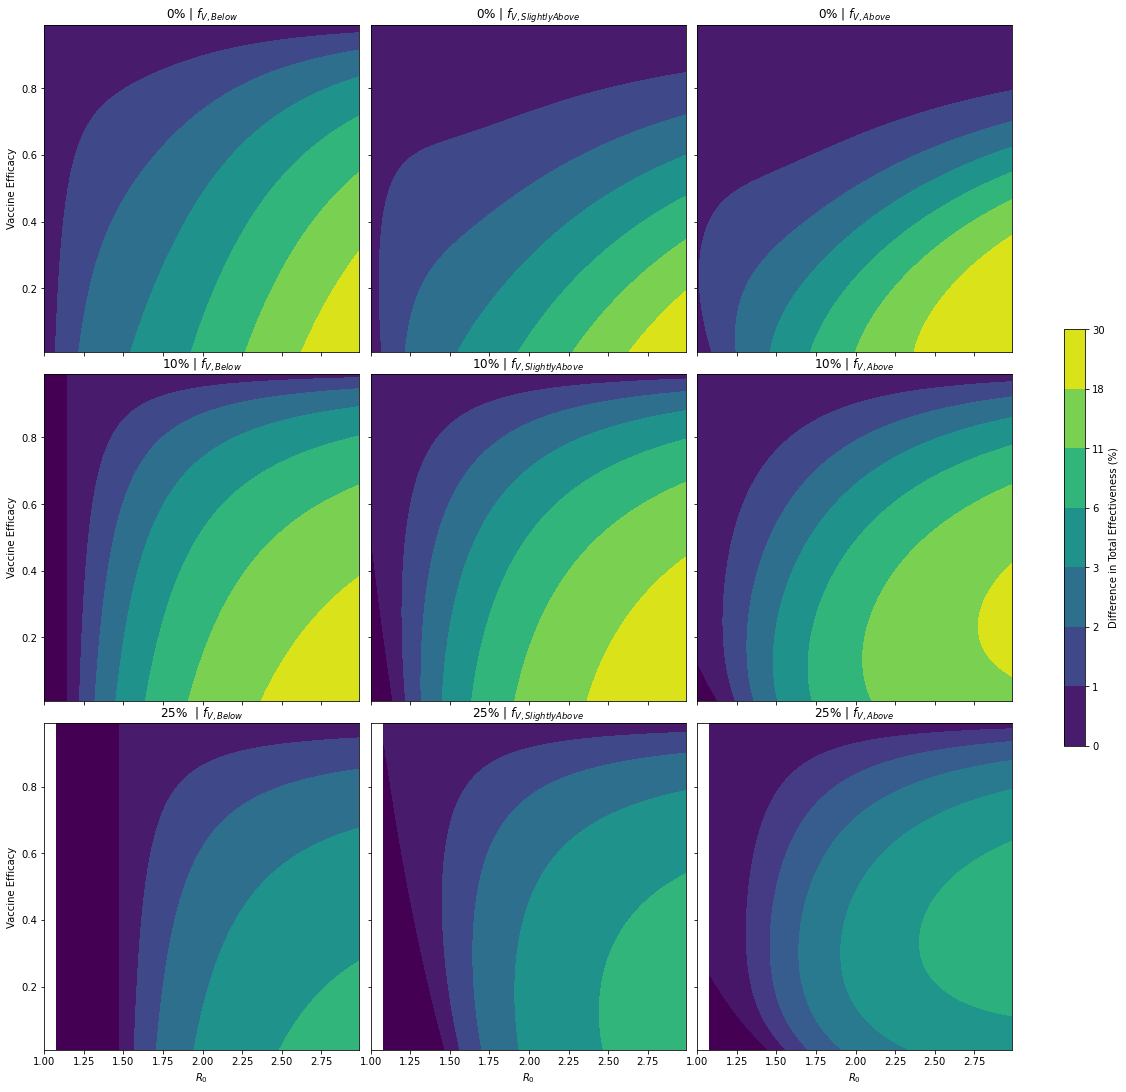

In [8]:
# define parameter values and initial conditions
sigma = 1/4; gamma = 1/4; t = 200
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
R0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

# run scenarios varying R0 values and vaccine efficacy
epi0_m60 = run_scenarios_size(y0, t, 0, R0s, sigma, gamma, epss, measured=60)
epi10_m60 = run_scenarios_size(y0, t, 0.1, R0s, sigma, gamma, epss, measured=60)
epi25_m60 = run_scenarios_size(y0, t, 0.25, R0s, sigma, gamma, epss, measured=60)

# plot difference in total effectiveness for each scenario
fig_3d = plot_scenarios_size(epi0_m60, epi10_m60, epi25_m60, dim=3)
fig_2d = plot_scenarios_size(epi0_m60, epi10_m60, epi25_m60, dim=2)

/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:819: RuntimeWarning: invalid value encountered in log
  axes[1,0].plot_surface(plot_r0, plot_eps, np.log(post10_below+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:822: RuntimeWarning: invalid value encountered in log
  axes[1,1].plot_surface(plot_r0, plot_eps, np.log(post10_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:829: RuntimeWarning: invalid value encountered in log
  axes[2,0].plot_surface(plot_r0, plot_eps, np.log(post30_below+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:832: RuntimeWarning: invalid value encountered in log
  axes[2,1].plot_surface(plot_r0, plot_eps, np.log(post30_slabove+1), norm=norm, rstride=1, cstride=1, cmap

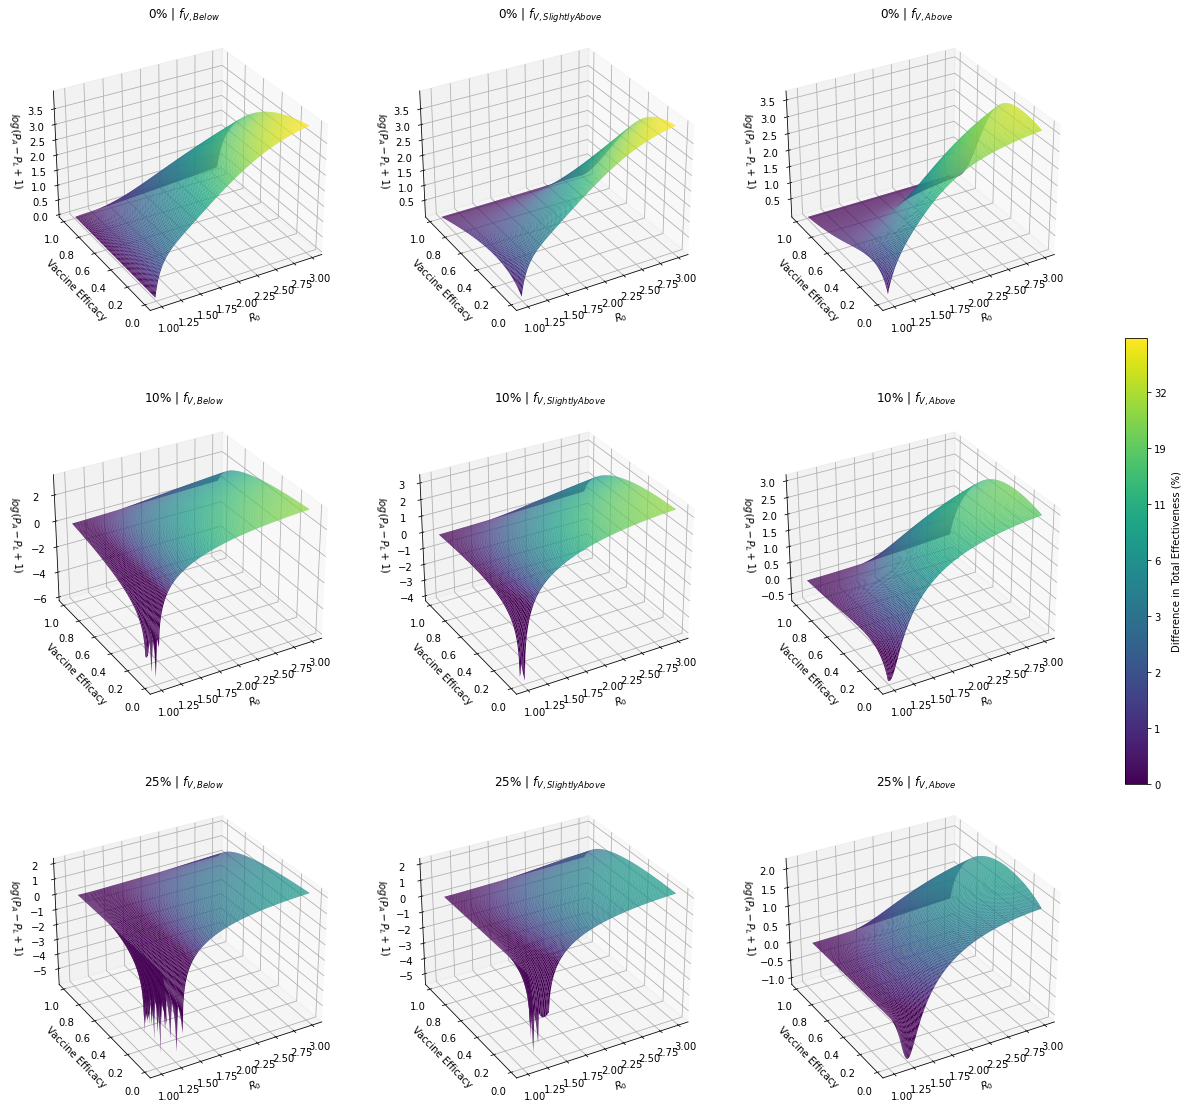

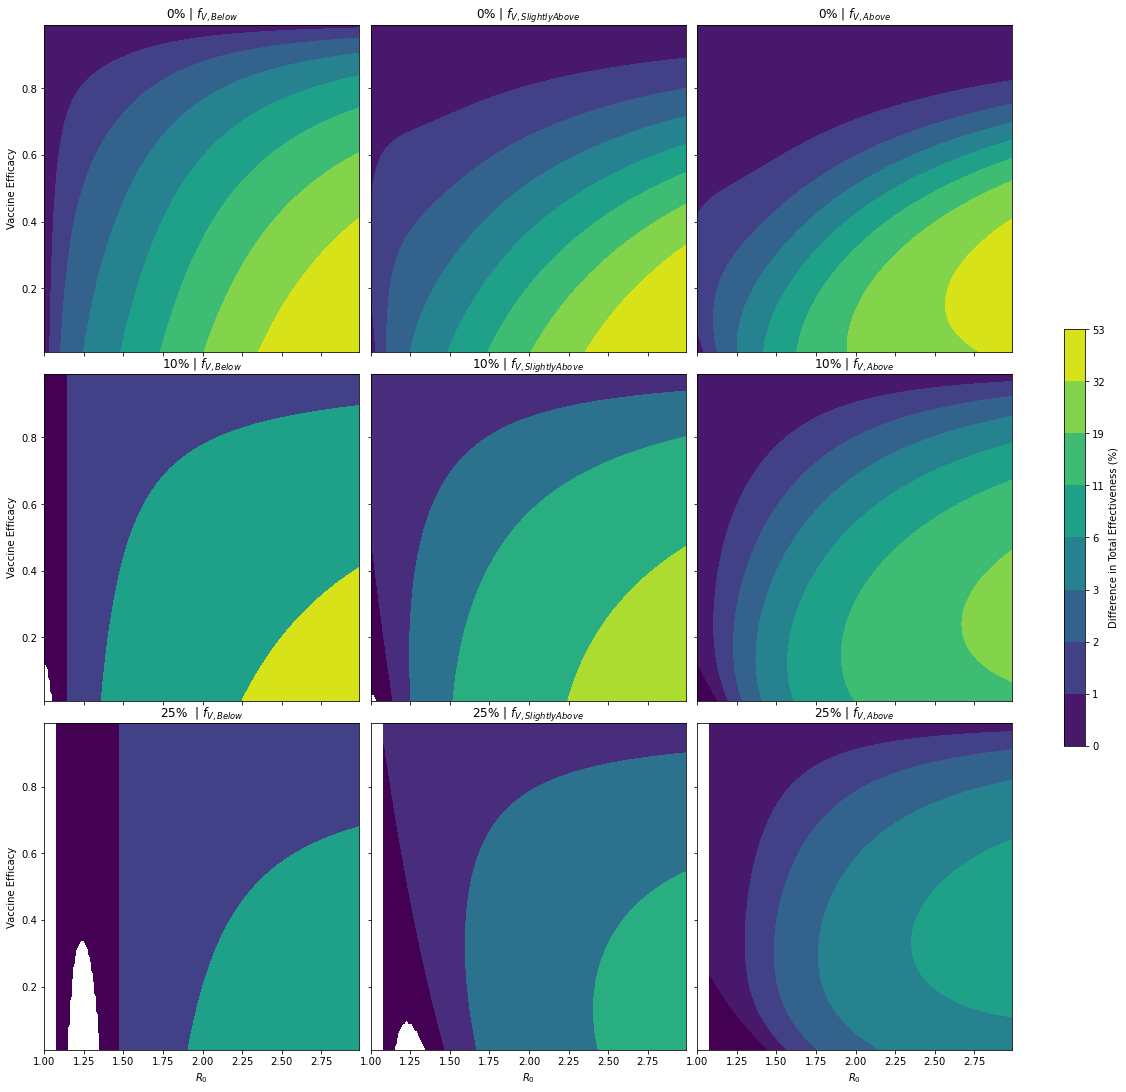

In [9]:
# define parameter values and initial conditions
sigma = 1/4; gamma = 1/4; t = 200
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
R0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

# run scenarios varying R0 values and vaccine efficacy
epi0_m100 = run_scenarios_size(y0, t, 0, R0s, sigma, gamma, epss, measured=100)
epi10_m100 = run_scenarios_size(y0, t, 0.1, R0s, sigma, gamma, epss, measured=100)
epi25_m100 = run_scenarios_size(y0, t, 0.25, R0s, sigma, gamma, epss, measured=100)

# plot difference in total effectiveness for each scenario
fig_3d = plot_scenarios_size(epi0_m100, epi10_m100, epi25_m100, dim=3)
fig_2d = plot_scenarios_size(epi0_m100, epi10_m100, epi25_m100, dim=2)

/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:847: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


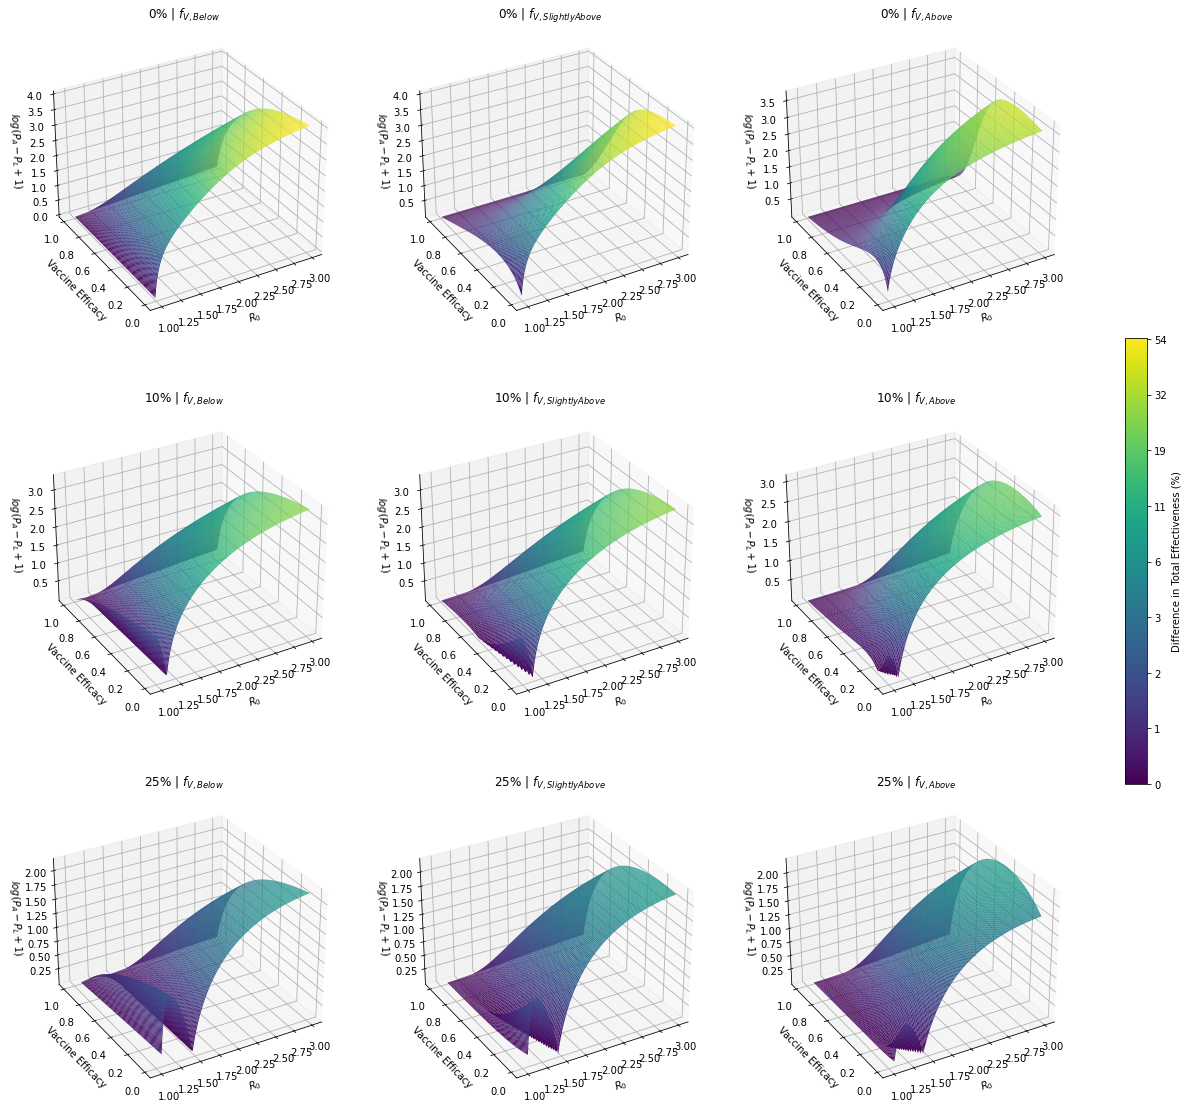

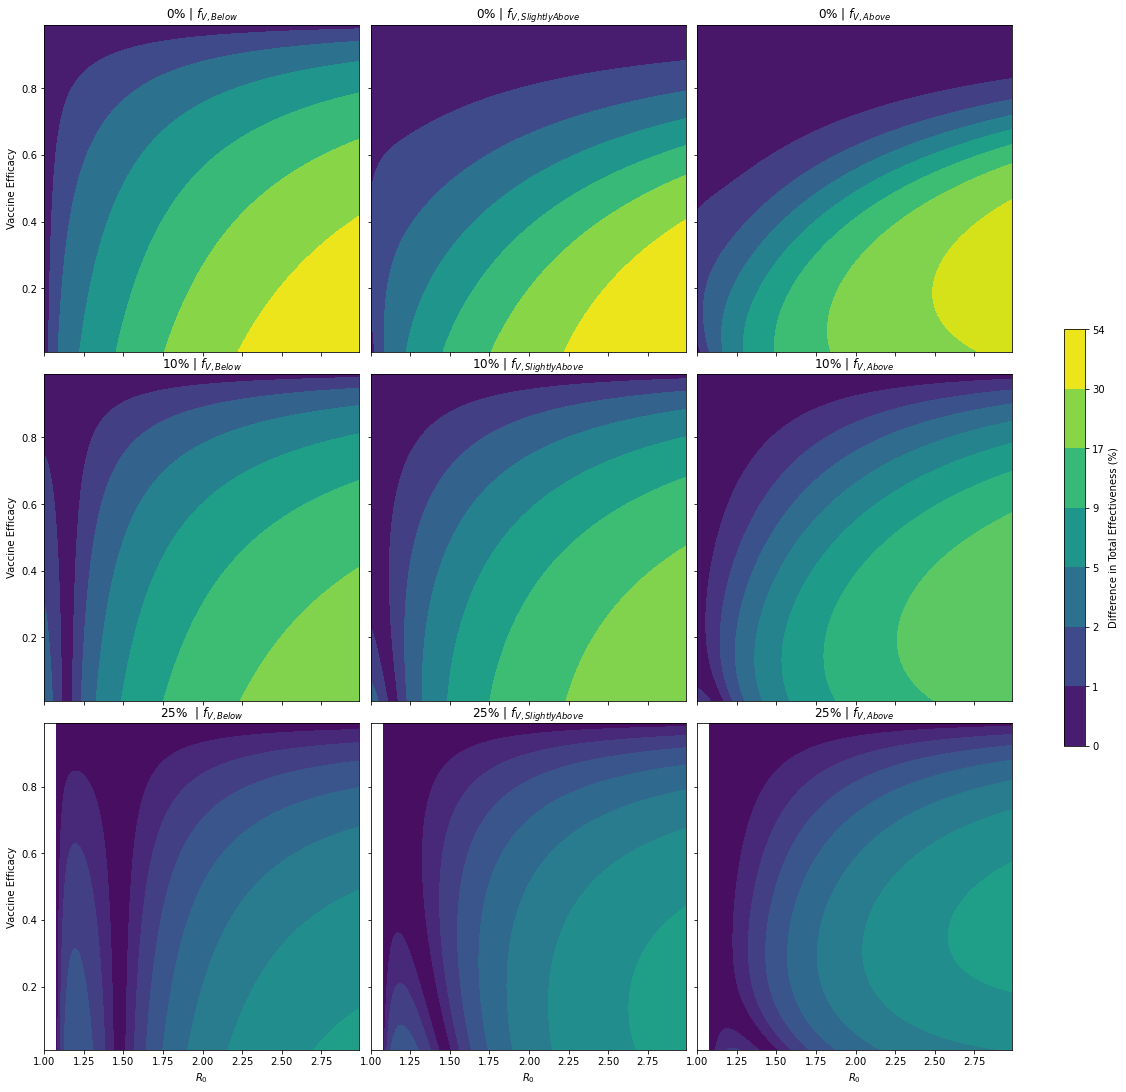

In [12]:
# define parameter values and initial conditions
sigma = 1/4; gamma = 1/4; t = 200
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
R0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

# run scenarios varying R0 values and vaccine efficacy
epi0_m200 = run_scenarios_size(y0, t, 0, R0s, sigma, gamma, epss, measured=200)
epi10_m200 = run_scenarios_size(y0, t, 0.1, R0s, sigma, gamma, epss, measured=200)
epi25_m200 = run_scenarios_size(y0, t, 0.25, R0s, sigma, gamma, epss, measured=200)

# plot difference in total effectiveness for each scenario and save figures
fig_3d = plot_scenarios_size(epi0_m200, epi10_m200, epi25_m200, dim=3)
fig_2d = plot_scenarios_size(epi0_m200, epi10_m200, epi25_m200, dim=2)